<a href="https://colab.research.google.com/github/lizmosquera/InteligenciaComputacional/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf_nightly-2.0-preview

ERROR: Could not find a version that satisfies the requirement tf_nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf_nightly-2.0-preview


In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print (tf.__version__)

2.2.0-rc3


In [0]:
def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend (time,slope=0):
  return slope*time

def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time <0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time))

def seasonality (time, period, amplitude=1,phase=0):
  """Repeats the same pattern at each period"""
  season_time=((time+phase)%period)/period
  return amplitude*seasonal_pattern(season_time)

def noise(time,noise_level=1,seed=None):
  rnd=np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

time=np.arange(4*365+1,dtype="float32")
baseline=10
series=trend(time,0.1)
baseline=10
amplitude=40
slope=0.05
noise_level=5

#ceate the series
series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
#update with noise
series +=noise(time,noise_level,seed=42)

split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

#linnear regresion
window_size=20
batch_size=32
shuffle_buffer_size=1000

In [0]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer): #crear un dataset
  dataset=tf.data.Dataset.from_tensor_slices(series) #create a dataset
  dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)#to slice the data up into the appropriate windows
  dataset=dataset.flat_map(lambda window: window.batch(window_size+1))#flatten the data out flatened into chunksin the suze of our window_size+1
  dataset=dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1],window[-1])) #shuflet it, choosing smaller number speeds
  dataset=dataset.batch(batch_size).prefetch(1)#size parameter =2 corresponde Yb
  return dataset

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set=windowed_dataset(x_train,window_size,batch_size=128,
                           shuffle_buffer=shuffle_buffer_size)
model=tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(40,return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x:x*100.0)
])
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))

optimizer=tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,#huber menos sensible a ootlyers
              metrics=["mae"])
history=model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 11ms/step - loss: 20.0033 - mae: 20.4056 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 20.0055 - mae: 20.4007 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 19.9369 - mae: 20.3928 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 19.8479 - mae: 20.3829 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 19.8854 - mae: 20.3715 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 11ms/step - loss: 19.8990 - mae: 20.3584 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 19.9070 - mae: 20.3437 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 19.7838 - mae: 20.3275 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 19.8020 - mae: 20.3089 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

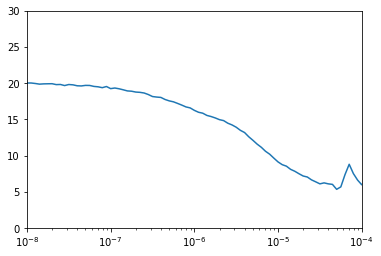

In [25]:
plt.semilogx(history.history["lr"],history.history["loss"])
plt.axis([1e-8,1e-4,0,30])

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset=windowed_dataset(x_train,window_size,batch_size=128,
                           shuffle_buffer=shuffle_buffer_size)
model=tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(40,return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x:x*100.0)
])

optimizer=tf.keras.optimizers.SGD(lr=15e-5,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,#huber menos sensible a ootlyers
              metrics=["mae"])
history=model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 11ms/step - loss: 58.0367 - mae: 59.4408
Epoch 2/400
8/8 [==============================] - 0s 11ms/step - loss: 28.4809 - mae: 29.1966
Epoch 3/400
8/8 [==============================] - 0s 10ms/step - loss: 19.7476 - mae: 20.1877
Epoch 4/400
8/8 [==============================] - 0s 10ms/step - loss: 15.9620 - mae: 16.3708
Epoch 5/400
8/8 [==============================] - 0s 11ms/step - loss: 14.6465 - mae: 14.7347
Epoch 6/400
8/8 [==============================] - 0s 10ms/step - loss: 23.0215 - mae: 22.9264
Epoch 7/400
8/8 [==============================] - 0s 10ms/step - loss: 23.4318 - mae: 23.9450
Epoch 8/400
8/8 [==============================] - 0s 11ms/step - loss: 18.3816 - mae: 18.9122
Epoch 9/400
8/8 [==============================] - 0s 10ms/step - loss: 16.4344 - mae: 16.3256
Epoch 10/400
8/8 [==============================] - 0s 11ms/step - loss: 19.8521 - mae: 20.1541
Epoch 11/400
8/8 [==============================]

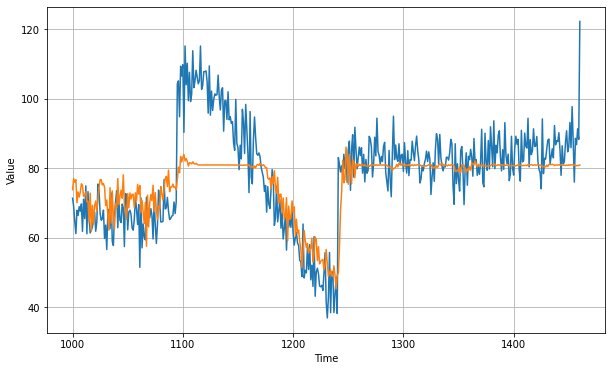

In [27]:
forecast=[] #forecast Vs DAta
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast=forecast[split_time-window_size:]
results=np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results)

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid,results).numpy()

7.5775933

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Legend does not support 'M' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Legend does not support 'A' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Legend does not support 'E' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Legend does not support 'M' instances.
A proxy artist may be used instead.
See: ht

<Figure size 432x288 with 0 Axes>

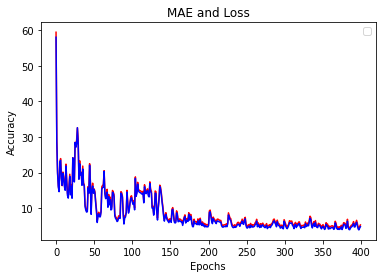

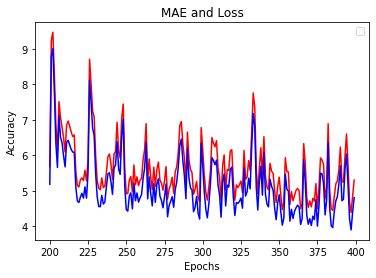

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae=history.history["mae"]
loss=history.history["loss"]

epochs=range(len(loss))

plt.plot(epochs,mae,'r')
plt.plot(epochs,loss,'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend("MAE","Loss")

plt.figure()

epochs_zoom=epochs[200:]
mae_zoom=mae[200:]
loss_zoom=loss[200:]

plt.plot(epochs_zoom,mae_zoom,'r')
plt.plot(epochs_zoom,loss_zoom,'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend("MAE","Loss")

plt.figure()